## 1. Data Setup

In [1]:
import h5py
import numpy as np

with h5py.File('../training_data_nofs.h5', 'r') as f:
    flux = f['flux'][:]
    params = f['parameters'][:]
    labels = f['labels'][:]

class_names = ['sw', 'msh', 'msp', 'ps', 'lobe']
class_to_idx = {'sw': 0, 'msh': 1, 'msp': 2, 'ps': 3, 'lobe':4}

PARAM_SIZE = params.shape[2]

import torch

X1_tensor = torch.log10(torch.from_numpy(flux).type(torch.float) + 1.0) # float is float32
X2_tensor = torch.from_numpy(params).type(torch.float) # float is float32
y_tensor = torch.from_numpy(labels).type(torch.LongTensor).squeeze()

nan_mask = torch.isnan(X2_tensor)
num_nan = torch.sum(nan_mask).item()
print("Number of NaNs:", num_nan)

# Replace NaN values with 0
X2_tensor = torch.nan_to_num(X2_tensor, nan=0.0)

# change to color, height, width, torch format
X1_tensor = torch.permute(X1_tensor, (0, 2, 1))
X1_tensor.size()

X2_tensor = torch.permute(X2_tensor, (0, 2, 1))

from sklearn.model_selection import train_test_split

# Split indices for training and testing
train_indices, test_indices = train_test_split(range(len(X1_tensor)), test_size=0.2, random_state=42)

# Use indices to split the datasets
X1_train, X1_test = X1_tensor[train_indices], X1_tensor[test_indices]
X2_train, X2_test = X2_tensor[train_indices], X2_tensor[test_indices]
y_train, y_test = y_tensor[train_indices], y_tensor[test_indices]




Number of NaNs: 6


In [2]:
min_vals_X1 = X1_train.min()
max_vals_X1 = X1_train.max()

min_vals_X2 = torch.zeros(PARAM_SIZE)
max_vals_X2 = torch.zeros(PARAM_SIZE)
for i in range(0,PARAM_SIZE):
    min_vals_X2[i] = X2_train[:,i,:].min()
    max_vals_X2[i] = X2_train[:,i,:].max()

min_vals_X1, max_vals_X1, min_vals_X2, max_vals_X2

(tensor(0.),
 tensor(8.1959),
 tensor([  0.6576,  19.5559, -23.5244]),
 tensor([   85.0814, 10612.0547,    16.6774]))

In [3]:
def min_max_scaling(tensor, min_val, max_val, feature_range=(0, 1)):
  """
  Scales a tensor to a specified range using min-max scaling.

  Args:
    tensor (torch.Tensor): The input tensor.
    feature_range (tuple, optional): The desired range for the scaled tensor. Defaults to (0, 1).

  Returns:
    torch.Tensor: The scaled tensor.
  """
  min_val = min_val #tensor.min()
  max_val = max_val #tensor.max()
  scaled_tensor = (tensor - min_val) / (max_val - min_val)

  #Adjust to the desired range
  scaled_tensor = scaled_tensor * (feature_range[1] - feature_range[0]) + feature_range[0]
  return scaled_tensor

def normalize_preserve_zero(tensor, min_val=None, max_val=None):
    """
    Normalize tensor to [-1, 1] while keeping zero at zero
    Uses piecewise linear transformation based on min/max values
    
    Args:
        tensor: Input tensor
        min_val: Minimum value (computed if None)
        max_val: Maximum value (computed if None)
    
    Returns:
        normalized tensor, min_val, max_val
    """
    if min_val is None:
        min_val = torch.min(tensor)
    if max_val is None:
        max_val = torch.max(tensor)
    
    # Get the absolute values of min and max for scaling
    abs_min = torch.abs(min_val)
    abs_max = torch.abs(max_val)
    
    # Initialize normalized tensor
    normalized = torch.zeros_like(tensor)
    
    # For negative values: map [min_val, 0] to [-1, 0]
    negative_mask = tensor < 0
    normalized[negative_mask] = tensor[negative_mask] / abs_min
    
    # For positive values: map [0, max_val] to [0, 1]
    positive_mask = tensor >= 0
    normalized[positive_mask] = tensor[positive_mask] / abs_max
    
    return normalized



min_vals_X1 = X1_train.min() #-X1_train.max()
max_vals_X1 = X1_train.max()
X1_train = min_max_scaling(X1_train, min_vals_X1, max_vals_X1, feature_range=(0, 1))
X1_test = (X1_test - min_vals_X1) / (max_vals_X1 - min_vals_X1)

min_vals_X2 = torch.zeros(PARAM_SIZE)
max_vals_X2 = torch.zeros(PARAM_SIZE)

for i in range(0,PARAM_SIZE-1):
    min_vals_X2[i] = X2_train[:,i,:].min()
    max_vals_X2[i] = X2_train[:,i,:].max()
    X2_train[:,i,:] = min_max_scaling(X2_train[:,i,:], min_vals_X2[i], max_vals_X2[i], feature_range=(0, 1))
    X2_test[:,i,:] = (X2_test[:,i,:] - min_vals_X2[i]) / (max_vals_X2[i] - min_vals_X2[i]) #(0,1)

min_vals_X2[2] = X2_train[:,2,:].min()
max_vals_X2[2] = X2_train[:,2,:].max()

X2_train[:,2,:] = normalize_preserve_zero(X2_train[:,2,:], min_vals_X2[2],max_vals_X2[2])
X2_test[:,2,:] = normalize_preserve_zero(X2_test[:,2,:], min_vals_X2[2],max_vals_X2[2])

print(X2_test[:,2,:].min())
print(X2_test[:,2,:].max())

X1_train = X1_train.unsqueeze(dim=1)
X1_test = X1_test.unsqueeze(dim=1)

tensor(-0.9995)
tensor(0.7139)


In [4]:
# # Test that zero stays zero
# zero_tensor = torch.tensor([0.0])
# zero_normalized= normalize_preserve_zero(zero_tensor, min_vals_X2[2],max_vals_X2[2])
# zero_normalized

In [5]:
X1_train.shape, X1_test.shape, X2_train.shape, X2_test.shape, y_train.shape, y_test.shape

(torch.Size([392, 1, 32, 40]),
 torch.Size([98, 1, 32, 40]),
 torch.Size([392, 3, 40]),
 torch.Size([98, 3, 40]),
 torch.Size([392]),
 torch.Size([98]))

In [6]:
X1_train.min(), X1_train.max()

(tensor(0.), tensor(1.))

In [7]:
np.average(X2_train[242, 0, :]), np.average(X2_train[242, 1, :]), np.average(X2_train[242, 2, :])

(0.31447214, 0.4902962, -0.022258539)

In [8]:
class_names = ['SW', 'MSH', 'MSP', 'PS', 'LOBE']

picked_indices = []
picked_values = []

# for val in range(5):  # 0 to 4
#     indices = (y_train == val).nonzero(as_tuple=True)[0]  # all positions of val
#     random_idx = indices[torch.randint(len(indices), (1,))]  # pick one at random
#     picked_indices.append(random_idx.item())
#     picked_values.append(val)

# print("Picked indices:", picked_indices)
# print("Picked values:", picked_values)

# import matplotlib.pyplot as plt
# indices = [35, 141, 6, 333, 127] #[180, 296, 232, 241, 226] #[174, 118, 158, 68, 49, 466]
# values = [0, 1, 2, 3, 4]
# torch.manual_seed(42)
# fig = plt.figure(figsize=(22, 10))
# rows, cols = 2, 3
# for i in range(1, 6): # rows * cols + 1
#     # random_idx = torch.randint(0, len(X1_train), size=[1]).item()
#     # print(X2_train_avg[indices[i-1],:])
#     img, label = X1_train[indices[i-1]], y_train[indices[i-1]]
#     fig.add_subplot(rows, cols, i)
#     plt.pcolormesh(img.squeeze(), cmap='nipy_spectral', shading="auto")
#     plt.colorbar()
#     plt.clim(0,1)
#     plt.title(class_names[label], fontsize=20)
#     plt.text(5, -1.5, "B =  %.2f, T = %.3f, X = %.2f" %(X2_train_avg[indices[i-1],0], X2_train_avg[indices[i-1],1], X2_train_avg[indices[i-1],2]), ha='left', va='top', fontsize=18) 
#     # plt.suptitle("B =  %.2f" %X2_train_avg[indices[i-1],0])
#     plt.axis(False);
#     # plt.savefig('Fluxexamples.png')

## 2. Model

In [9]:
import torch
from torch import nn

# Define the CNN model for flux data only
class FluxCNNModel(nn.Module):
    def __init__(self):
        super(FluxCNNModel, self).__init__()
        self.conv2d_1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv2d_2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv2d_3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(64 * 5 * 4, 64)  # Flattened size for input image size (1, 40, 32)
        self.dropout = nn.Dropout(p=0.5) # to avoid overfitting
        self.output = nn.Linear(64, 5)

    def forward(self, x1):
        x1 = self.conv2d_1(x1)
        x1 = self.conv2d_2(x1)
        x1 = self.conv2d_3(x1)
        x1 = torch.flatten(x1, start_dim=1)
        x1 = self.fc1(x1)
        x = self.output(x1)
        return x

# Initialize model
model = FluxCNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

model

FluxCNNModel(
  (conv2d_1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2d_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2d_3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1280, out_features=64, bias=True)
  (dropout): Dropout(p=0.5, inplace=F

In [10]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Simulated plasma parameter data
# Shape: (num_samples, num_channels, sequence_length)
 # X2_train torch.Size([473, 3, 40]),
 # X2_test torch.Size([119, 3, 40]),

X2_train_avg = np.array(X2_train.mean(axis=2))   # shape becomes (473, 3)
X2_test_avg = np.array(X2_test.mean(axis=2))     # shape becomes (119, 3)

# Labels
# y_train and y_test, shapes 473, 119 in Torch Tensor Form

# Train RF
rf = RandomForestClassifier(n_estimators=100, random_state=42)
# rf = RandomForestClassifier(n_estimators=100)
rf.fit(X2_train_avg, np.array(y_train))

# Predict on new data
# Evaluate
y_pred = rf.predict(X2_test_avg)
print(classification_report(np.array(y_test), y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        29
           3       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        12

    accuracy                           1.00        98
   macro avg       1.00      1.00      1.00        98
weighted avg       1.00      1.00      1.00        98



In [11]:
rf.predict_proba(X2_test_avg).shape

(98, 5)

In [12]:
# import matplotlib.pyplot as plt
# from matplotlib.gridspec import GridSpec
# import torch

# indices = [35, 141, 6, 333, 127]
# values = [0, 1, 2, 3, 4]
# torch.manual_seed(42)

# fig = plt.figure(figsize=(22, 10))

# # Use GridSpec for better control - 2 rows, 6 columns
# gs = GridSpec(2, 6, figure=fig, hspace=0.3, wspace=0.3)

# # Define subplot positions
# subplot_positions = [
#     gs[0, 0:2],   # Top row, left (columns 0-1)
#     gs[0, 2:4],   # Top row, center (columns 2-3)
#     gs[0, 4:6],   # Top row, right (columns 4-5)
#     gs[1, 1:3],   # Bottom row, left-center (columns 1-2) - centered
#     gs[1, 3:5]    # Bottom row, right-center (columns 3-4) - centered
# ]

# for i in range(5):
#     # Create subplot at specified position
#     ax = fig.add_subplot(subplot_positions[i])
    
#     # Your existing plotting code
#     img, label = X1_train[indices[i]], y_train[indices[i]]
    
#     im = plt.pcolormesh(img.squeeze(), cmap='nipy_spectral', shading="auto")
#     plt.colorbar(im, ax=ax)  # Specify which axis the colorbar belongs to
#     plt.clim(0, 1)
#     plt.title(class_names[label], fontsize=20)
#     plt.text(5, -1.5, "B = %.2f, T = %.3f, X = %.2f" % (
#         X2_train_avg[indices[i], 0], 
#         X2_train_avg[indices[i], 1], 
#         X2_train_avg[indices[i], 2]
#     ), ha='left', va='top', fontsize=18)
#     plt.axis(False)

# # Save the figure once, outside the loop
# plt.savefig('Fluxexamples.png', dpi=300, bbox_inches='tight')
# plt.show()




## 3. Training 

In [13]:
# from torchmetrics import Accuracy

# # setup metric and make sure it's on target device
# acc_fn = Accuracy(task="multiclass", num_classes=5)

# results = {"epochs": [],
#            "train_loss": [],
#            "train_acc": [],
#            "test_loss": [],
#            "test_acc": []}

# # Training loop
# num_epochs = 15
# batch_size = 8
# num_samples = len(X1_train)
# for epoch in range(num_epochs):
#     train_loss, train_acc = 0, 0
#     # print(epoch)
#     for i in range(0, num_samples, batch_size):
#         batch_X1 = X1_train[i:i+batch_size]
#         batch_y = y_train[i:i+batch_size]

#         outputs = model(batch_X1)

#         loss = criterion(outputs, batch_y)
#         train_loss += loss
#         train_acc += acc_fn(outputs.argmax(dim=1), batch_y)
#         # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss.item():.4f}, acc: {train_acc.item()*100:.2f}")
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
    
#     train_loss /= (len(X1_train)/batch_size)
#     train_acc /= (len(X1_train)/batch_size)
#     print(f"Epoch [{epoch+1}/{num_epochs}]: Train Loss: {train_loss.item():.4f}: Train acc: {train_acc.item()*100:.2f}%")
#     results["epochs"].append(epoch)
#     results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
#     results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)


#     test_loss, test_acc = 0, 0
#     # Put model into evaluation mode
#     model.eval()

#     with torch.inference_mode():
#         for i in range(0, len(X1_test)-2, batch_size):
#             batch_X1 = X1_test[i:i+batch_size]
#             batch_y = y_test[i:i+batch_size]
#             # print(batch_y)

#             test_pred = model(batch_X1)
#             # print(test_pred.argmax(dim=1))
#             test_loss += criterion(test_pred , batch_y)
#             test_acc += acc_fn(test_pred.argmax(dim=1), batch_y)

#         # test loss and accuracy average per batch
#         test_loss /= (len(X1_test)/batch_size)
#         test_acc /= (len(X1_test)/batch_size)
#         print(f"\nEpoch [{epoch+1}/{num_epochs}]: Validation loss: {test_loss:.4f}: Test acc: {test_acc*100:.2f}%\n")
#         results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
#         results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

#         if test_acc > 0.979:  # Condition to exit loop
#         # if test_loss < 0.01:  # Condition to exit loop
#             print("Stopping early: Accuracy exceeded threshold!")
#             break  # Exiting the loop
# print("Training complete!")

In [14]:
import copy
from torchmetrics import Accuracy

# setup metric and make sure it's on target device
acc_fn = Accuracy(task="multiclass", num_classes=5)
results = {"epochs": [],
           "train_loss": [],
           "train_acc": [],
           "test_loss": [],
           "test_acc": []}

# Early stopping parameters
patience = 5
best_test_acc = 0
patience_counter = 0
best_model_weights = None

# Training loop
num_epochs = 15
batch_size = 8
num_samples = len(X1_train)

for epoch in range(num_epochs):
    train_loss, train_acc = 0, 0
    model.train()  # Make sure model is in training mode
    
    for i in range(0, num_samples, batch_size):
        batch_X1 = X1_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]
        outputs = model(batch_X1)
        loss = criterion(outputs, batch_y)
        train_loss += loss
        train_acc += acc_fn(outputs.argmax(dim=1), batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss /= (len(X1_train)/batch_size)
    train_acc /= (len(X1_train)/batch_size)
    print(f"Epoch [{epoch+1}/{num_epochs}]: Train Loss: {train_loss.item():.4f}: Train acc: {train_acc.item()*100:.2f}%")
    
    results["epochs"].append(epoch)
    results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
    
    # Evaluation phase
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for i in range(0, len(X1_test)-2, batch_size):
            batch_X1 = X1_test[i:i+batch_size]
            batch_y = y_test[i:i+batch_size]
            test_pred = model(batch_X1)
            test_loss += criterion(test_pred , batch_y)
            test_acc += acc_fn(test_pred.argmax(dim=1), batch_y)
        
        test_loss /= (len(X1_test)/batch_size)
        test_acc /= (len(X1_test)/batch_size)
        print(f"\nEpoch [{epoch+1}/{num_epochs}]: Validation loss: {test_loss:.4f}: Test acc: {test_acc*100:.2f}%\n")
        
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)
        
        # Early stopping logic
        current_test_acc = test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc
        
        if current_test_acc > best_test_acc:
            best_test_acc = current_test_acc
            best_model_weights = copy.deepcopy(model.state_dict())
            patience_counter = 0
            print(f"New best test accuracy: {best_test_acc*100:.2f}% - Model weights saved")
        else:
            patience_counter += 1
            print(f"No improvement in test accuracy for {patience_counter}/{patience} epochs")
        
        # Check if we should stop early
        if patience_counter >= patience:
            print(f"Early stopping triggered! No improvement for {patience} consecutive epochs.")
            print(f"Restoring best model weights (test accuracy: {best_test_acc*100:.2f}%)")
            model.load_state_dict(best_model_weights)
            break
        
        # # Original early stopping condition (optional - you can remove this)
        # if current_test_acc > 0.979:
        #     print("Stopping early: Accuracy exceeded threshold!")
        #     break

print("Training complete!")
print(f"Best test accuracy achieved: {best_test_acc*100:.2f}%")

Epoch [1/15]: Train Loss: 1.6153: Train acc: 18.88%

Epoch [1/15]: Validation loss: 1.5680: Test acc: 18.37%

New best test accuracy: 18.37% - Model weights saved
Epoch [2/15]: Train Loss: 1.1708: Train acc: 48.98%

Epoch [2/15]: Validation loss: 0.5220: Test acc: 79.59%

New best test accuracy: 79.59% - Model weights saved
Epoch [3/15]: Train Loss: 0.4615: Train acc: 84.44%

Epoch [3/15]: Validation loss: 0.1740: Test acc: 93.88%

New best test accuracy: 93.88% - Model weights saved
Epoch [4/15]: Train Loss: 0.1869: Train acc: 97.19%

Epoch [4/15]: Validation loss: 0.0692: Test acc: 95.92%

New best test accuracy: 95.92% - Model weights saved
Epoch [5/15]: Train Loss: 0.1313: Train acc: 96.68%

Epoch [5/15]: Validation loss: 0.0641: Test acc: 94.90%

No improvement in test accuracy for 1/5 epochs
Epoch [6/15]: Train Loss: 0.0894: Train acc: 97.19%

Epoch [6/15]: Validation loss: 0.0414: Test acc: 96.94%

New best test accuracy: 96.94% - Model weights saved
Epoch [7/15]: Train Loss: 0.

In [15]:
from tqdm.auto import tqdm


# Make predictions with trained CNN model and rf
num_samples = len(X1_test)
y_pred_cnn = []
model.eval()
with torch.inference_mode():
    for i in tqdm(range(0, num_samples, batch_size)):
        batch_X1 = X1_test[i:i+batch_size]
        batch_y = y_test[i:i+batch_size]
        
        y_logit = model(batch_X1)
        y_cnn = torch.softmax(y_logit, dim=1)

        y_pred_cnn.append(y_cnn)
# print(y_pred_cnn)

# # prediction from cnn model
y_pred_cnn_tensor = torch.cat(y_pred_cnn) # shape: (119, 6)
# y_pred_cnn_tensor.shape

# #prediction from random forest
rf_output = rf.predict_proba(X2_test_avg) # shape: (119, 6)
# rf_output
# print(rf_output)

# Fuse probablities (e.g., by averaging)

combined_output= (y_pred_cnn_tensor.numpy() + rf_output) / 2
y_pred_numpy = np.argmax(combined_output, axis=1)

y_pred_tensor = torch.Tensor(y_pred_numpy)
y_pred_tensor

  0%|          | 0/13 [00:00<?, ?it/s]

tensor([2., 3., 2., 2., 2., 1., 3., 0., 2., 0., 3., 4., 2., 0., 1., 3., 2., 2.,
        1., 0., 3., 4., 2., 3., 3., 3., 4., 0., 0., 2., 4., 4., 1., 1., 3., 3.,
        3., 3., 0., 0., 2., 2., 1., 4., 3., 0., 3., 2., 2., 2., 2., 3., 4., 1.,
        4., 3., 2., 3., 1., 4., 2., 2., 3., 1., 1., 0., 3., 0., 2., 2., 1., 4.,
        1., 2., 2., 3., 1., 1., 3., 4., 1., 1., 2., 2., 4., 1., 3., 3., 2., 3.,
        0., 2., 3., 1., 2., 3., 0., 2.])

In [16]:
# import matplotlib.pyplot as plt
# import torchmetrics, mlxtend
# print(f"mlxtend version: {mlxtend.__version__}")

# from torchmetrics import ConfusionMatrix
# from mlxtend.plotting import plot_confusion_matrix

# # setup confusion matrix instance and compare predictions to target
# confmat = ConfusionMatrix(num_classes=5, task='multiclass')
# confmat_tensor = confmat(preds=y_pred_tensor,
#                          target=y_test)

# # 3. Plot the confusion matrix
# fig, ax = plot_confusion_matrix(
#     conf_mat=confmat_tensor.numpy(),  # matplotlib likes working with NumPy 
#     class_names=class_names, # turn the row and column labels into class names
#     figsize=(10,7));
# fig.savefig('ConfMatrix.png', dpi=fig.dpi)
# plt.show()

In [17]:
# association = {0:'sw', 1:'msh', 2:'msp', 3:'ps', 4:'lobe'}

# from utilities import roc_plot_rf

# fig = roc_plot_rf(y_pred_tensor, y_test, association=association)
# plt.show()

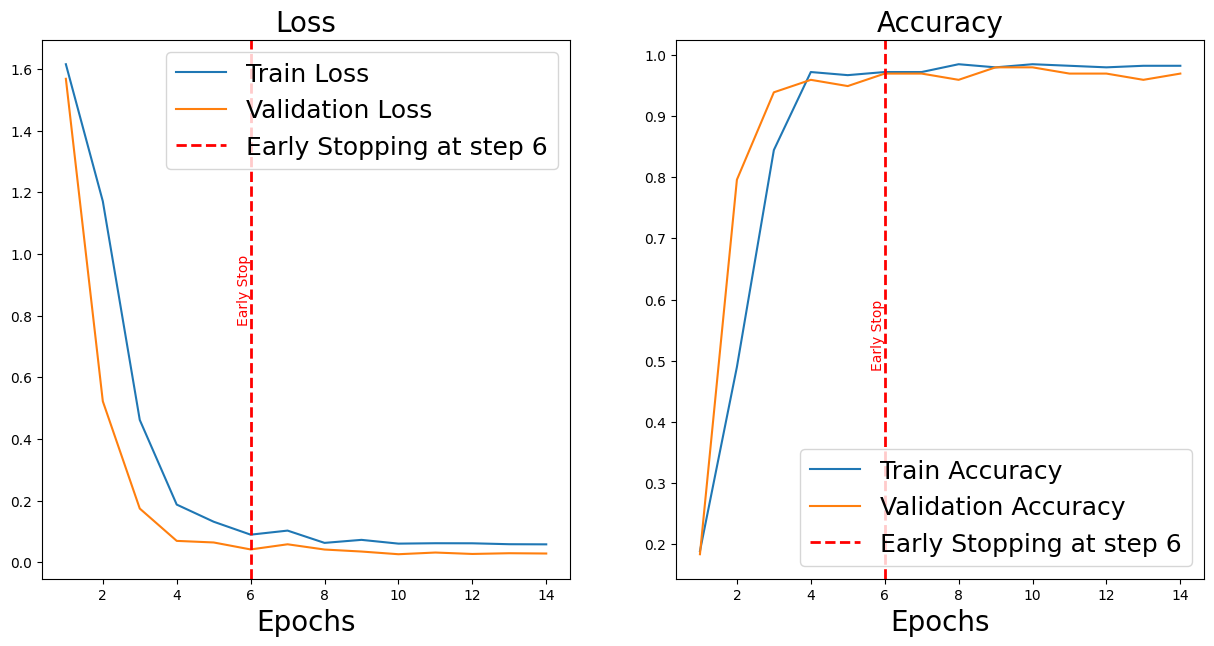

In [18]:
# This is only from CNN model
import matplotlib.pyplot as plt
# from utilities import plot_loss_curves
def plot_loss_curves_local(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    steps = [num + 1 for num in epochs ]
    early_stop = 6
    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(steps, loss, label='Train Loss')
    plt.plot(steps, test_loss, label='Validation Loss')
    plt.title('Loss', fontsize=20)
    plt.xlabel('Epochs', fontsize=20)
    plt.axvline(x=early_stop,color='red',linestyle='--',linewidth=2, label=f'Early Stopping at step 6')   
    plt.text(x=early_stop,y=1, s='Early Stop', color='red', rotation=90, ha='right', va='top')
    plt.legend(fontsize=18)

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(steps, accuracy, label='Train Accuracy')
    plt.plot(steps, test_accuracy, label='Validation Accuracy')
    plt.title('Accuracy', fontsize=20)
    plt.xlabel('Epochs', fontsize=20)
    plt.axvline(x=early_stop,color='red',linestyle='--',linewidth=2, label=f'Early Stopping at step 6')   
    plt.text(x=early_stop,y=0.6, s='Early Stop', color='red', rotation=90, ha='right', va='top')
    plt.legend(fontsize=18)
    plt.legend(fontsize=18);
    plt.savefig('LossAccuracy.png')
    plt.show()
plot_loss_curves_local(results)

In [19]:
# from torchmetrics import F1Score

# # Initialize F1Score for multiclass task
# f1_metric_multiclass = F1Score(task="multiclass", num_classes=5, average="macro") # or "micro", "weighted"

# # Compute F1 score
# f1_score_multiclass = f1_metric_multiclass(y_pred_tensor, y_test)
# print(f"Multiclass F1 Score (macro avg): {f1_score_multiclass}")

In [20]:
# from torchmetrics import functional  #precision_recall

# from torchmetrics.classification import MulticlassPrecision
# metric = MulticlassPrecision(num_classes=5)

# metric(y_pred_tensor, y_test)

# mcp = MulticlassPrecision(num_classes=5, average=None)
# mcp(y_pred_tensor, y_test)

In [21]:
# from torchmetrics.classification import MulticlassRecall

# metric = MulticlassRecall(num_classes=5)
# metric(y_pred_tensor, y_test)

# mcr = MulticlassRecall(num_classes=5, average=None)
# mcr(y_pred_tensor, y_test)

In [22]:
print(classification_report(y_test, y_pred_tensor))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        29
           3       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        12

    accuracy                           1.00        98
   macro avg       1.00      1.00      1.00        98
weighted avg       1.00      1.00      1.00        98



## 4. Save the model

In [23]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create cnn model save path
CNN_MODEL_NAME = "model15_logflux_lr005_nofs_X0.pth"
CNN_MODEL_SAVE_PATH = MODEL_PATH / CNN_MODEL_NAME

# Save the cnn model state dict
print(f"Saving CNN model to: {CNN_MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=CNN_MODEL_SAVE_PATH)

import joblib
# Create rf model save path
RF_MODEL_NAME = "model15_parameters_nofs.pkl"
RF_MODEL_SAVE_PATH = MODEL_PATH / RF_MODEL_NAME

# Save the RF model
joblib.dump(rf, RF_MODEL_SAVE_PATH )
print(f"Saving RF model to: {RF_MODEL_SAVE_PATH}")



Saving CNN model to: models/model15_logflux_lr005_nofs_X0.pth
Saving RF model to: models/model15_parameters_nofs.pkl


In [34]:
# # Instantiate a fresh instance of multiinputmodel
# loaded_CNN = FluxCNNModel()
# # RFModel = rf()



# # Load model state dict
# loaded_CNN.load_state_dict(torch.load(f="./models/model14_logflux_lr005_nofs_X0.pth"))

# print(f"Loaded model:\n{FluxCNNModel}")

# # Load RF model
# import joblib
# from sklearn.ensemble import RandomForestClassifier
# RF_MODEL_SAVE_PATH = './models/model14_parameters_nofs.pkl'
# loaded_rf = joblib.load(RF_MODEL_SAVE_PATH)
# print("Loaded model:", loaded_rf)

# model = loaded_CNN
# rf = loaded_rf

Loaded model:
<class '__main__.FluxCNNModel'>
Loaded model: RandomForestClassifier(n_estimators=50, random_state=42)


In [35]:
# from predict import predictions_cnn_rf
# trange = ['2015-09-19/00:07:00', '2015-09-19/20:00:00'] # flank
# predictions_cnn_rf(model, rf, trange)

In [36]:
import os
import torch
from torch import nn
# path for data 
os.environ["SPEDAS_DATA_DIR"] = "/Volumes/datadir/mmsdata"  #"/Users/naah5403/data"

import pyspedas
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import more_itertools
import xarray as xr
from pytplot import tplot, del_data, options, get_data, get, store_data, ylim, tplot_options, tlimit
from pyspedas import tinterpol, time_string

def predictions_cnn_rf(cnn_model:torch.nn.Module, rf_model, trange):

    tname = trange[0].replace('/','_').replace('-','').replace(':','')
    probe = '1'
    pyspedas.mms.fgm(trange=trange, data_rate='srvy', probe=probe)
    pyspedas.mms.fpi(trange=trange,center_measurement=True, data_rate='fast',datatype=['dis-moms'], probe=probe)
    pyspedas.mms.mec(trange=trange, data_rate='srvy', probe=probe)
    
    BgseN ='mms1_fgm_b_gse_srvy_l2'
    DeniN = 'mms1_dis_numberdensity_fast'
    ViN = 'mms1_dis_bulkv_gse_fast'
    TiperpN = 'mms1_dis_tempperp_fast'
    TiparaN = 'mms1_dis_temppara_fast'
    posN = 'mms1_mec_r_gse'
    
    omni_flux = get_data('mms1_dis_energyspectr_omni_fast')
    energy = get_data('mms1_dis_energy_fast')
    
    # Interpol to ion fpi time 30ms
    tinterpol(BgseN, DeniN)
    tinterpol(posN, DeniN)
    
    #times, Bgse = get_data(BgseN+'-itrp')
    
    ni = get_data(DeniN)
    B = get_data(BgseN+'-itrp')
    Vi = get_data(ViN)
    Tiperp = get_data(TiperpN)
    Tipara = get_data(TiparaN)
    pos = get_data(posN+'-itrp')
    
    df_time = time_string(ni.times)
    df_ni = pd.DataFrame(ni.y, columns = ['ni'],index = [df_time])
    df_B = pd.DataFrame(B.y, columns = ['Bx','By','Bz','Btot'],index = [df_time])
    df_Vi = pd.DataFrame(Vi.y, columns = ['Vx','Vy','Vz'],index = [df_time])
    df_Vitot = pd.DataFrame(np.linalg.norm(df_Vi.values, axis=1), columns = ['vitot'], index = [df_time])
    df_Tiperp = pd.DataFrame(Tiperp.y, columns = ['Tiperp'],index = [df_time])
    df_Tipara = pd.DataFrame(Tipara.y, columns = ['Tipara'],index = [df_time])
    df_Ti = pd.concat([df_Tiperp,df_Tipara], axis=1)
    df_Titot = df_Ti.mean(axis=1)
    df_pos = pd.DataFrame(pos.y/6378., columns = ['X','Y','Z'],index = [df_time])
    
    df_final = pd.concat([df_B, df_ni, df_Vi, df_Vitot, df_Ti, df_Titot, df_pos], axis=1)
    df_final.columns = ['bx', 'by', 'bz', 'btot', 'ni', 'vix', 'viy', 'viz', 'vitot', 'Tiperp', 'Tipara', 'Titot', 'X', 'Y', 'Z']
    
    
    
    block_size = 40
    blocks = list(more_itertools.chunked(df_final.values, block_size))
    blocks = [np.array(x) for x in blocks]
    
    x_input_all = np.array(blocks[:-1])
    
    timestamps = list(more_itertools.chunked(df_final.index, block_size))
    timestamps = np.array(timestamps[:-1])
    
    index = pd.DatetimeIndex(timestamps[:,0,0])
    
    block_size = 40
    blocks = list(more_itertools.chunked(omni_flux.y, block_size))
    blocks = [np.array(x) for x in blocks]
    
    x_input_flux = np.array(blocks[:-1])
    
    
    X1 = x_input_flux
    
    X2_1 = x_input_all[:,:,3]  # btot
    X2_1 = np.expand_dims(X2_1, axis=2)
    X2_2 = x_input_all[:,:,11:13]  # T_tot, X
    
    X2 = np.concatenate((X2_1, X2_2), axis=2)
    
    import torch
    X1_tensor_test = torch.log10(torch.from_numpy(np.array(X1)).type(torch.float)+1.0) # float is float32
    X2_tensor_test = torch.from_numpy(np.array(X2)).type(torch.float) # float is float32
    
    nan_mask = torch.isnan(X2_tensor_test)
    num_nan = torch.sum(nan_mask).item()
    print("Number of NaNs:", num_nan)
    
    # Replace NaN values with 0
    X2_tensor_test = torch.nan_to_num(X2_tensor_test, nan=0.0)
    
    # # 200 sample model
    # min_vals_X1 = torch.tensor(0.)
    # max_vals_X1 = torch.tensor(8.0439)
    # min_vals_X2 = torch.tensor([  0.3847,  45.2129, -24.1444])
    # max_vals_X2 = torch.tensor([   86.2452, 10419.9775,    12.7759])
    # smaller 100 model
    min_vals_X1 = torch.tensor(0.)
    max_vals_X1 = torch.tensor(8.1959)
    min_vals_X2 = torch.tensor([  0.6576,  19.5559, -23.5244])
    max_vals_X2 = torch.tensor([   85.0814, 10612.0547,    16.6774])

    PARAM_SIZE = 3
    
    X1_tensor_test = (X1_tensor_test - min_vals_X1) / ( max_vals_X1 - min_vals_X1)
    
    def normalize_preserve_zero(tensor, min_val=None, max_val=None):
        """
        Normalize tensor to [-1, 1] while keeping zero at zero
        Uses piecewise linear transformation based on min/max values
        
        Args:
            tensor: Input tensor
            min_val: Minimum value (computed if None)
            max_val: Maximum value (computed if None)
        
        Returns:
            normalized tensor, min_val, max_val
        """
        if min_val is None:
            min_val = torch.min(tensor)
        if max_val is None:
            max_val = torch.max(tensor)
        
        # Get the absolute values of min and max for scaling
        abs_min = torch.abs(min_val)
        abs_max = torch.abs(max_val)
        
        # Initialize normalized tensor
        normalized = torch.zeros_like(tensor)
        
        # For negative values: map [min_val, 0] to [-1, 0]
        negative_mask = tensor < 0
        normalized[negative_mask] = tensor[negative_mask] / abs_min
        
        # For positive values: map [0, max_val] to [0, 1]
        positive_mask = tensor >= 0
        normalized[positive_mask] = tensor[positive_mask] / abs_max
        
        return normalized
    
    for i in range(0,PARAM_SIZE-1):
        X2_tensor_test[:,:,i] = (X2_tensor_test[:,:,i] - min_vals_X2[i]) / ( max_vals_X2[i] - min_vals_X2[i])

    X2_tensor_test[:,:,2] = normalize_preserve_zero(X2_tensor_test[:,:,2], min_vals_X2[2],max_vals_X2[2])

    # change to color, height, width, torch format
    X1_tensor_test = torch.permute(X1_tensor_test, (0, 2, 1))
    # X1_tensor_test.size()
    
    X2_tensor_test = torch.permute(X2_tensor_test, (0, 2, 1))
    X2_test_avg = np.array(X2_tensor_test.mean(axis=2))     # shape becomes (length, 3)
    
    
    X1_tensor_test = X1_tensor_test.unsqueeze(dim=1)
    
    # Make predictions with trained model
    from tqdm.auto import tqdm	
    
    # Make predictions with trained CNN model and rf
    num_samples = len(X1_tensor_test)
    batch_size = 8
    
    y_pred_cnn = []
    cnn_model.eval()
    with torch.inference_mode():
        for i in tqdm(range(0, num_samples, batch_size)):
            batch_X1 = X1_tensor_test[i:i+batch_size]
            
            y_logit = cnn_model(batch_X1)
            y_cnn = torch.softmax(y_logit, dim=1)
    
            y_pred_cnn.append(y_cnn)


    # # prediction from cnn model
    y_pred_cnn_tensor = torch.cat(y_pred_cnn)

    # original_max_cnn = np.argmax(y_pred_cnn_tensor.numpy(), axis=1)
    # print(original_max_indices)
    # print(original_max_indices.shape)
    # indices_day_1 = np.where((X2_test_avg[:,2] < 0) & ((original_max_cnn == 1)))[0]
    # print(indices_day_1)
    # y_pred_cnn_tensor[indices_day_1, 3] = y_pred_cnn_tensor[indices_day_1, 1]

    # indices_day_3 = np.where((X2_test_avg[:,2] > 0) & ((original_max_cnn == 3)))[0]  
    # print(indices_day_3)
    # y_pred_cnn_tensor[indices_day_3, 3] = 0.0 #y_pred_cnn_tensor[indices_day_3, 3]

    # indices_day_4 = np.where((X2_test_avg[:,2] > 0) & ((original_max_cnn == 4)))[0]  
    # print(indices_day_4)
    # y_pred_cnn_tensor[indices_day_4, 4] = 0.0

    # prediction from random forest
    rf_output = rf_model.predict_proba(X2_test_avg)
    # original_max_rf = np.argmax(rf_output, axis=1)
    # indices_day_3_rf = np.where((X2_test_avg[:,2] > 0) & ((original_max_rf == 3)))[0]  
    # print(indices_day_3_rf)
    # rf_output[indices_day_3_rf, 3] = 0.0 #y_pred_cnn_tensor[indices_day_3, 3]

    # prediction from cnn only
    y_cnn = np.argmax(y_pred_cnn_tensor.numpy(), axis=1)
   # # Find indexes where x > 0 and label is 3 or 4, replace with 2 PS or LOBE to MSP
   #  indices_day = np.where((X2_test_avg[:,2] > 0) & ((y_cnn == 3) | (y_cnn == 4)))[0]
   #  y_cnn[indices_day] = 2   

    y_cnn = pd.DataFrame(y_cnn)    
    y_cnn = y_cnn.set_index(index)


    # prediction from rf only
    y_rf = np.argmax(rf_output, axis=1)
    y_rf = pd.DataFrame(y_rf)    
    y_rf = y_rf.set_index(index)

    # Fuse probablities (e.g., by averaging)
    
    combined_output= (y_pred_cnn_tensor.numpy() + rf_output ) / 2
    y_pred_numpy = np.argmax(combined_output, axis=1)

    
    y_pred_tensor = torch.Tensor(y_pred_numpy)

    def replace_pair_values(tensor, pair_list, new_value):
        """
        pair_list: list of (a,b) pairs to consider (will treat (a,b) and (b,a) the same)
        new_value: scalar to set on both elements of each matched pair
        """
        # Build mask for pairs in y[:-1] vs y[1:]
        a = tensor[:-1]
        b = tensor[1:]
        # Start with all False
        mask_pairs = torch.zeros_like(a, dtype=torch.bool)
        for p in pair_list:
            p0, p1 = p
            mask_pairs |= ((a == p0) & (b == p1)) | ((a == p1) & (b == p0))
    
        # Expand to full-length mask marking both members of each matched pair
        mask_full = torch.zeros_like(tensor, dtype=torch.bool)
        mask_full[:-1] |= mask_pairs
        mask_full[1:]  |= mask_pairs
    
        tensor[mask_full] = new_value
        return tensor

    # Sequentially apply the same groups as your original code:
    # 1) (1<->2) -> 5  MSH <-> MSP  -> MP
    replace_pair_values(y_pred_tensor, [(1,2)], 5)
    
    # 2) (0<->1) -> 6  SW <-> MSH -> BS
    replace_pair_values(y_pred_tensor, [(0,1)], 6)
    
    # 3) (3<->4) -> 7 PS <-> LOBE -> PSBL
    replace_pair_values(y_pred_tensor, [(3,4)], 7)

    
    y_pred_tensor = pd.DataFrame(y_pred_tensor)
    y_pred_tensor = y_pred_tensor.set_index(index)

    B = pd.DataFrame(X2_test_avg[:,0])
    B = B.set_index(index)
    T = pd.DataFrame(X2_test_avg[:,1])
    T = T.set_index(index)
    X = pd.DataFrame(X2_test_avg[:,2])
    X = X.set_index(index)

    
    figure, axis = plt.subplots(5, 1,  figsize=(20, 12), sharex=True, constrained_layout=True) #sharex=True
    pcm=axis[0].pcolormesh(np.array(time_string(energy.times)).astype("datetime64[ns]"),energy.y[0],
                                   np.log10(np.transpose(omni_flux.y[:,:])),cmap='nipy_spectral',shading='auto')
    axis[0].set_yscale('log')
    figure.colorbar(pcm, ax=axis[0], label="$keV/(cm^2~s~sr~keV)$", pad=0)
    # pcm.set_clim(3,6)
    
    size=14
    plt.rc('font', size=size)          # controls default text sizes
    plt.rc('axes', titlesize=size)     # fontsize of the axes title
    plt.rc('axes', labelsize=size)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=size+2)    # legend fontsize
    plt.rc('figure', titlesize=size)  # fontsize of the figure title
    
    axis[1].plot(index, B, 'ok', label='Magnetic Field')
    axis[1].plot(index, T, 'or', label='Temperature')
    axis[1].plot(index, X, 'ob', label='Position')
    axis[1].grid()
    axis[1].set_ylabel('Normalized Parameters')
    axis[1].legend()    
    

    axis[2].plot(index, y_rf, 'oc', label='RF')
    # axis[2].plot(index, y_pred_tensor, 'ok')
    # axis[2].yaxis.set_ticks(np.arange(0,9,1))
    # axis[2].yaxis.set_ticklabels(['SW', 'FS', 'MSH', 'MSP', 'PS', 'LOBE', 'MP', 'BS', 'PSBL'])
    axis[2].yaxis.set_ticks(np.arange(0,5,1))
    axis[2].yaxis.set_ticklabels(['SW', 'MSH', 'MSP', 'PS', 'LOBE'])
    axis[2].grid()
    axis[2].set_ylabel('RF Predictions')
    axis[2].legend()    
    
    axis[3].plot(index, y_cnn, 'om', label='CNN')
    # axis[2].plot(index, y_pred_tensor, 'ok')
    # axis[2].yaxis.set_ticks(np.arange(0,9,1))
    # axis[2].yaxis.set_ticklabels(['SW', 'FS', 'MSH', 'MSP', 'PS', 'LOBE', 'MP', 'BS', 'PSBL'])
    axis[3].yaxis.set_ticks(np.arange(0,5,1))
    axis[3].yaxis.set_ticklabels(['SW', 'MSH', 'MSP', 'PS', 'LOBE'])
    axis[3].grid()
    axis[3].set_ylabel('CNN Predictions')
    axis[3].legend() 
    
    axis[4].plot(index, y_pred_tensor, 'ok')
    axis[4].yaxis.set_ticks(np.arange(0,8,1))
    axis[4].yaxis.set_ticklabels(['SW', 'MSH', 'MSP', 'PS', 'LOBE', 'MP', 'BS', 'PSBL'])
    axis[4].grid()
    axis[4].set_ylabel('Predictions')
    axis[4].legend() 
    # axis[1].set_xlabel('time (UTC)')
    
    # plt.savefig("CNN_RF02_Case_"+tname+".png")
    plt.show()


24-Sep-25 10:22:43: Loading /Volumes/datadir/mmsdata/mms/mms1/fgm/srvy/l2/2019/12/mms1_fgm_srvy_l2_20191207_v5.222.0.cdf
24-Sep-25 10:22:46: Loading /Volumes/datadir/mmsdata/mms/mms1/fpi/fast/l2/dis-moms/2019/12/mms1_fpi_fast_l2_dis-moms_20191207040000_v3.4.0.cdf
24-Sep-25 10:22:46: Loading /Volumes/datadir/mmsdata/mms/mms1/fpi/fast/l2/dis-moms/2019/12/mms1_fpi_fast_l2_dis-moms_20191207060000_v3.4.0.cdf
24-Sep-25 10:22:46: Loading /Volumes/datadir/mmsdata/mms/mms1/fpi/fast/l2/dis-moms/2019/12/mms1_fpi_fast_l2_dis-moms_20191207080000_v3.4.0.cdf
24-Sep-25 10:22:46: Loading /Volumes/datadir/mmsdata/mms/mms1/fpi/fast/l2/dis-moms/2019/12/mms1_fpi_fast_l2_dis-moms_20191207100000_v3.4.0.cdf
24-Sep-25 10:22:46: Loading /Volumes/datadir/mmsdata/mms/mms1/fpi/fast/l2/dis-moms/2019/12/mms1_fpi_fast_l2_dis-moms_20191207120000_v3.4.0.cdf
24-Sep-25 10:22:46: Loading /Volumes/datadir/mmsdata/mms/mms1/fpi/fast/l2/dis-moms/2019/12/mms1_fpi_fast_l2_dis-moms_20191207140000_v3.4.0.cdf
24-Sep-25 10:22:46: L

Number of NaNs: 0


  0%|          | 0/39 [00:00<?, ?it/s]

24-Sep-25 10:22:50: /var/folders/nr/rrbzw4215sdgt24vls1fg3hw0091p4/T/ipykernel_62851/3919415600.py:286: RuntimeWarning: divide by zero encountered in log10
  np.log10(np.transpose(omni_flux.y[:,:])),cmap='nipy_spectral',shading='auto')

24-Sep-25 10:22:50: /var/folders/nr/rrbzw4215sdgt24vls1fg3hw0091p4/T/ipykernel_62851/3919415600.py:333: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axis[4].legend()



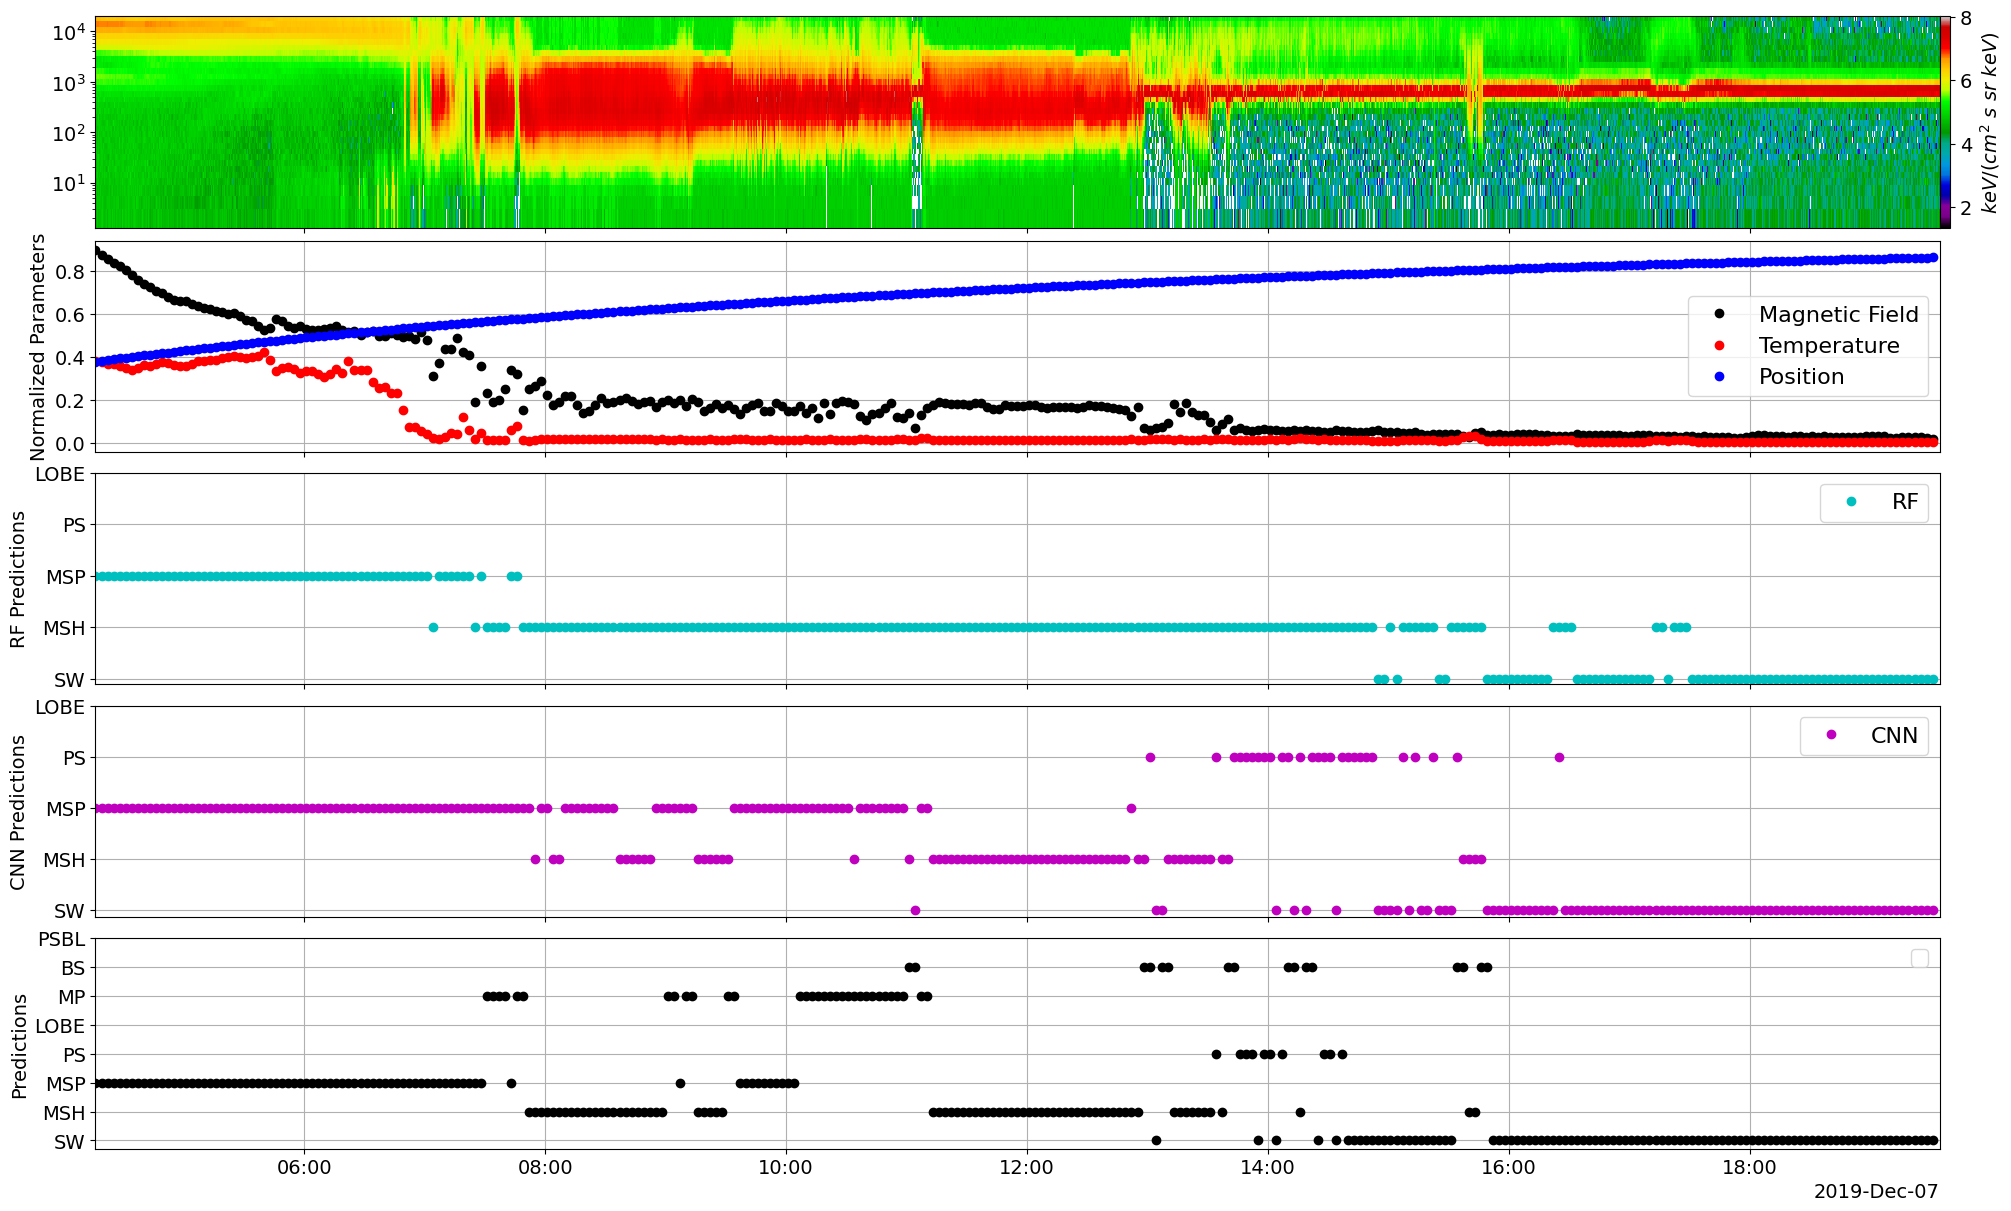

In [44]:
# import predict
# trange = ['2023-05-02/00:00:00', '2023-05-02/23:59:00']
# predict.predictions_cnn_rf(model, rf, trange)

# trange = ['2019-11-09/00:05:00', '2019-11-09/23:59:00']
trange = ['2019-12-07/00:05:00', '2019-12-07/23:59:00']
# trange = ['2022-01-09/00:00:00', '2022-01-09/23:59:00']
# trange = ['2023-04-17/00:00:00', '2023-04-17/23:59:00']
# trange = ['2023-05-02/00:00:00', '2023-05-02/23:59:00']
# trange = ['2025-03-10/00:00:00', '2025-03-10/23:59:00']
# trange = ['2017-01-31/00:00:00', '2017-01-31/23:59:00']

## nightside use case
# trange = ['2019-07-13/00:00:00', '2019-07-13/23:59:00']
# trange = ['2022-07-18/00:00:00', '2022-07-18/23:59:00']
# trange = ['2021-08-31/00:00:00', '2021-08-31/23:59:00']
# trange = ['2024-08-24/00:00:00','2024-08-24/23:59:00']


## flank use case
# trange = ['2015-09-15/00:08:00', '2015-09-15/20:00:00'] # flank
# trange = ['2015-09-19/00:07:00', '2015-09-19/20:00:00'] # flank

predictions_cnn_rf(model, rf, trange)

In [38]:
with h5py.File('../test_data2.h5', 'r') as f:
    flux = f['flux'][:]
    params = f['parameters'][:]
    labels = f['labels'][:]

class_names = ['sw', 'msh', 'msp', 'ps', 'lobe']
class_to_idx = {'sw': 0, 'msh': 1, 'msp': 2, 'ps': 3, 'lobe':4}

PARAM_SIZE = params.shape[2]

import torch

X1_tensor_test = torch.log10(torch.from_numpy(flux).type(torch.float)+1.0) # float is float32
X2_tensor_test = torch.from_numpy(params).type(torch.float) # float is float32
y_tensor_test = torch.from_numpy(labels).type(torch.LongTensor).squeeze()

nan_mask = torch.isnan(X2_tensor_test)
num_nan = torch.sum(nan_mask).item()
# print("Number of NaNs:", num_nan)

# Replace NaN values with 0
X2_tensor_test = torch.nan_to_num(X2_tensor_test, nan=0.0)


# min_vals_X1 = torch.tensor(0.)
# max_vals_X1 = torch.tensor(8.0439)
# min_vals_X2 = torch.tensor([  0.3847,  45.2129, -24.1444])
# max_vals_X2 = torch.tensor([   86.2452, 10419.9775,    12.7759])

# smaller 100 model
min_vals_X1 = torch.tensor(0.)
max_vals_X1 = torch.tensor(8.1959)
min_vals_X2 = torch.tensor([  0.6576,  19.5559, -23.5244])
max_vals_X2 = torch.tensor([   85.0814, 10612.0547,    16.6774])

PARAM_SIZE = 3
    
X1_tensor_test = (X1_tensor_test - min_vals_X1) / ( max_vals_X1 - min_vals_X1)
    
    
# for i in range(0,PARAM_SIZE):
#     if i ==2 :
#         X2_tensor_test[:,:,i] = (X2_tensor_test[:,:,i] - min_vals_X2[i]) / ( max_vals_X2[i] - min_vals_X2[i])
#         X2_tensor_test[:,:,i] = X2_tensor_test[:,:,i]*2.0 - 1.0
#     else:
#         X2_tensor_test[:,:,i] = (X2_tensor_test[:,:,i] - min_vals_X2[i]) / ( max_vals_X2[i] - min_vals_X2[i])
    
for i in range(0,PARAM_SIZE-1):
    X2_tensor_test[:,:,i] = (X2_tensor_test[:,:,i] - min_vals_X2[i]) / ( max_vals_X2[i] - min_vals_X2[i])

X2_tensor_test[:,:,2] = normalize_preserve_zero(X2_tensor_test[:,:,2], min_vals_X2[2],max_vals_X2[2])
    
# change to color, height, width, torch format
X1_tensor_test = torch.permute(X1_tensor_test, (0, 2, 1))
    
X2_tensor_test = torch.permute(X2_tensor_test, (0, 2, 1))
X2_test_avg = np.array(X2_tensor_test.mean(axis=2))     # shape becomes (length, 3)
    
    
X1_tensor_test = X1_tensor_test.unsqueeze(dim=1)
    
# Make predictions with trained model
from tqdm.auto import tqdm


# Make predictions with trained CNN model and rf
num_samples = len(X1_tensor_test)
y_pred_cnn = []
model.eval()
with torch.inference_mode():
    for i in tqdm(range(0, num_samples, batch_size)):
        batch_X1 = X1_tensor_test[i:i+batch_size]
        
        y_logit = model(batch_X1)
        y_cnn = torch.softmax(y_logit, dim=1)

        y_pred_cnn.append(y_cnn)
# print(y_pred_cnn)


# # prediction from cnn model
y_pred_cnn_tensor = torch.cat(y_pred_cnn) # shape: (119, 6)
# y_pred_cnn_tensor.shape

# original_max_indices = np.argmax(y_pred_cnn_tensor.numpy(), axis=1)
# indices_day_1 = np.where((X2_test_avg[:,2] < 0) & ((original_max_indices == 1)))[0]
# print(indices_day_1)
# y_pred_cnn_tensor[indices_day_1, 3] = y_pred_cnn_tensor[indices_day_1, 1]

# indices_day_3 = np.where((X2_test_avg[:,2] > 0) & ((original_max_indices == 3)))[0]
# print(indices_day_3)
# y_pred_cnn_tensor[indices_day_3, 2] = 0 #y_pred_cnn_tensor[indices_day_3, 3]

# indices_day_4 = np.where((X2_test_avg[:,2] > 0) & ((original_max_indices == 4)))[0]  
# print(indices_day_4)
# y_pred_cnn_tensor[indices_day_4, 4] = 0.0

# #prediction from random forest
rf_output = rf.predict_proba(X2_test_avg) # shape: (119, 6)
# original_max_rf = np.argmax(rf_output, axis=1)
# indices_day_1_rf = np.where((X2_test_avg[:,2] < 0) & ((original_max_rf == 1)))[0]  
# print(indices_day_1_rf)
# rf_output[indices_day_1_rf, 1] = 0.0 #y_pred_cnn_tensor[indices_day_3, 3]


# # Fuse probablities (e.g., by averaging)

combined_output= (y_pred_cnn_tensor.numpy() + rf_output) / 2
y_pred_numpy = np.argmax(combined_output, axis=1)

y_pred_tensor = torch.Tensor(y_pred_numpy)
# y_pred_tensor

  0%|          | 0/63 [00:00<?, ?it/s]

mlxtend version: 0.23.3


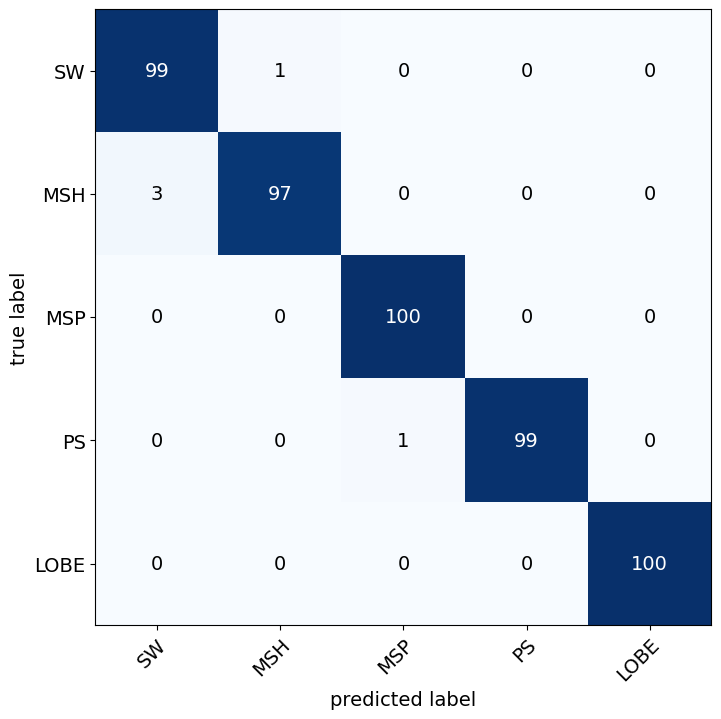

In [39]:
import matplotlib.pyplot as plt
import torchmetrics, mlxtend
print(f"mlxtend version: {mlxtend.__version__}")

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
class_names = ['SW', 'MSH', 'MSP', 'PS', 'LOBE']

# setup confusion matrix instance and compare predictions to target
confmat = ConfusionMatrix(num_classes=5, task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=y_tensor_test)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),  # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(8,8));

fig.savefig('ConfMatrix.png', dpi=fig.dpi)
plt.show()

In [30]:
# plt.plot(y_pred_tensor, 'r')
# plt.plot(y_tensor_test, 'b')

n_classes 5
AUC macro average :0.99375
AUC micro average :0.99375


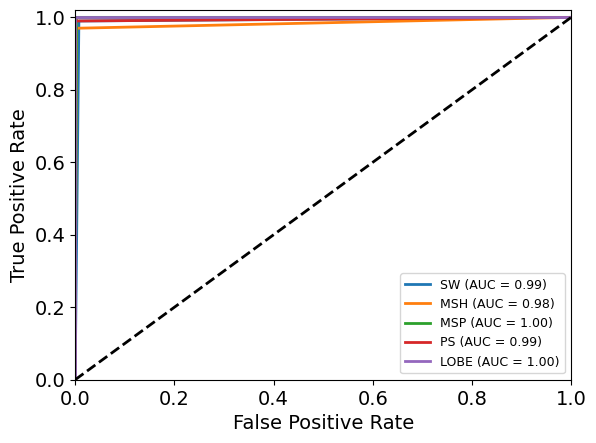

In [40]:
association = {0:'SW', 1:'MSH', 2:'MSP', 3:'PS', 4:'LOBE'}

from utilities import roc_plot_rf

fig = roc_plot_rf(y_pred_tensor, y_tensor_test, association=association)
plt.show()

In [41]:
print(classification_report(y_tensor_test, y_pred_tensor, target_names = class_names))

              precision    recall  f1-score   support

          SW       0.97      0.99      0.98       100
         MSH       0.99      0.97      0.98       100
         MSP       0.99      1.00      1.00       100
          PS       1.00      0.99      0.99       100
        LOBE       1.00      1.00      1.00       100

    accuracy                           0.99       500
   macro avg       0.99      0.99      0.99       500
weighted avg       0.99      0.99      0.99       500



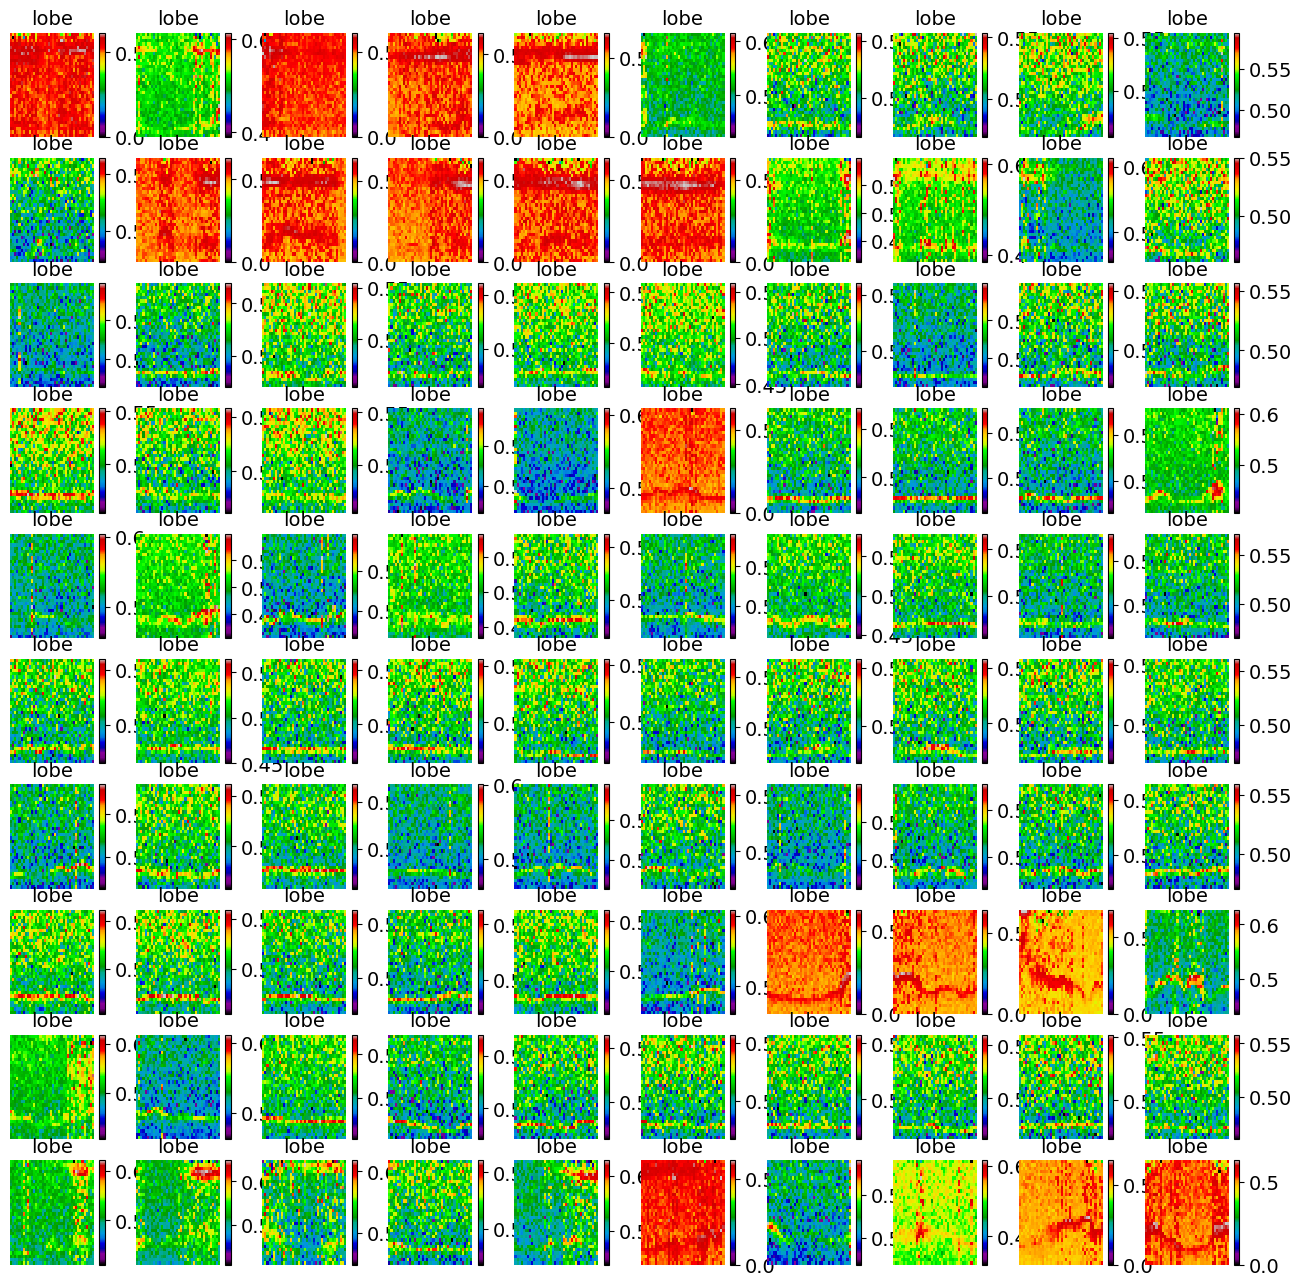

In [50]:
class_names = ['sw', 'msh', 'msp', 'ps', 'lobe']

idx = np.where(y_tensor_test == 4)
# print(idx)
import matplotlib.pyplot as plt

torch.manual_seed(42)
fig = plt.figure(figsize=(16, 16))
rows, cols = 10, 10
for i in range(1,  rows * cols + 1):
    ind = i-1
    k = idx[0][ind]
    img, label = X1_tensor_test[k], y_tensor_test[k]
    fig.add_subplot(rows, cols, i)
    plt.pcolormesh(img.squeeze(), cmap='nipy_spectral', shading="auto")
    plt.colorbar()
    # plt.clim(0,0.25)
    plt.title(class_names[label])
    plt.axis(False);
    # plt.savefig('Fluxexamples.png')
